<div style="border:2px solid #2196F3; border-radius:10px; padding:16px; background:#f9f9ff">

<h3>⚙️ Notebook 2 — Preprocessing & Baseline Modeling</h3>

**Purpose**  
- Load the curated dataset (~54 features) derived from Notebook 1.  
- Apply preprocessing:  
  - Handle missing values  
  - Encode categorical variables  
  - Scale numerical features  
- Split data into train/test sets.  
- Train baseline models (Logistic Regression, Random Forest, XGBoost) to establish performance benchmarks.  
- Evaluate using ROC-AUC, LogLoss, precision/recall, and calibration plots.  

**Inputs**  
- <code>data/processed/loan_default_slim55.parquet</code> (default, safe to load in-memory)  
- <code>data/processed/loan_default_full55.parquet</code> (already prepared in Notebook 1, only load in downstream notebooks if resources allow)  
- <code>columns_to_keep.txt</code> (list of selected features)  

**Outputs**  
- Preprocessing pipeline object  
- Baseline model artifacts for comparison in Notebook 3  

⚠️ **Memory Reminder**  
Do not flip `USE_SAMPLE=False` in Notebook 1. The full dataset is already saved as <code>loan_default_full55.parquet</code>.  
Notebook 2 should always start from the slim55 sample for exploration and prototyping. The full dataset can be used later for scaling experiments if hardware permits.  

</div>

### <div class="alert alert-info" align = center> Imports</div>

In [1]:
# Core
import os, sys, json, pathlib, warnings
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing & modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Gradient boosting
from xgboost import XGBClassifier

# Utility
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")


### <div class="alert alert-info" align = center> Functions</div>

<div class="alert alert-info"><strong>Load The Data</strong></div>

In [2]:
# === Dataset Loading ===

USE_SAMPLE = False   # flip to False when ready for full dataset

# Paths
datapath = pathlib.Path("data/processed")
feat_file = pathlib.Path("data/processed/columns_to_keep.txt")

# Load kept features
with open(feat_file) as f:
    features_to_keep = [line.strip() for line in f if line.strip()]

# Always include target
target = "target_default"
features_final = features_to_keep

# Load data
if USE_SAMPLE:
    print("🔹 Using SAMPLE dataset (10%)")
    df = pd.read_parquet(datapath / "loan_default_slim55.parquet").sample(frac=0.1, random_state=42)
else:
    print("🔹 Using FULL dataset")
    df = pd.read_parquet(datapath / "loan_default_full55.parquet")

# Keep only final features + target
df = df[features_final]

print(f"✅ Loaded dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")
df.head()


🔹 Using FULL dataset
✅ Loaded dataset: 298 rows, 55 columns


,loan_amnt,funded_amnt_inv,int_rate,annual_inc,mths_since_last_record,open_acc,pub_rec,out_prncp,out_prncp_inv,total_rec_prncp,...,mths_since_last_major_derog_is_missing,annual_inc_joint_is_missing,il_util_is_missing,mths_since_recent_bc_dlq_is_missing,mths_since_recent_revol_delinq_is_missing,sec_app_open_act_il_is_missing,target_default,emp_length,emp_length_is_missing,int_rate_trunc
0,25000.0,25000.0,16.139999,30000.0,90.0,6.0,0.0,0.0,0.0,25000.0,...,1,0,0,0,0,0,0,< 1 year,0,16.1399
1,1075.0,800.0,11.800000,57000.0,90.0,5.0,0.0,0.0,0.0,1075.0,...,0,1,0,0,0,1,0,5 years,0,11.8000
2,10000.0,10000.0,11.800000,100000.0,90.0,7.0,0.0,0.0,0.0,10000.0,...,1,1,0,0,0,1,0,2 years,0,11.8000
3,10000.0,10000.0,26.309999,35500.0,90.0,8.0,0.0,0.0,0.0,10000.0,...,1,1,0,1,1,1,0,1 year,0,26.3099
4,30000.0,30000.0,18.940001,225000.0,90.0,10.0,0.0,30000.0,30000.0,0.0,...,1,1,0,1,0,1,1,8 years,0,18.9400


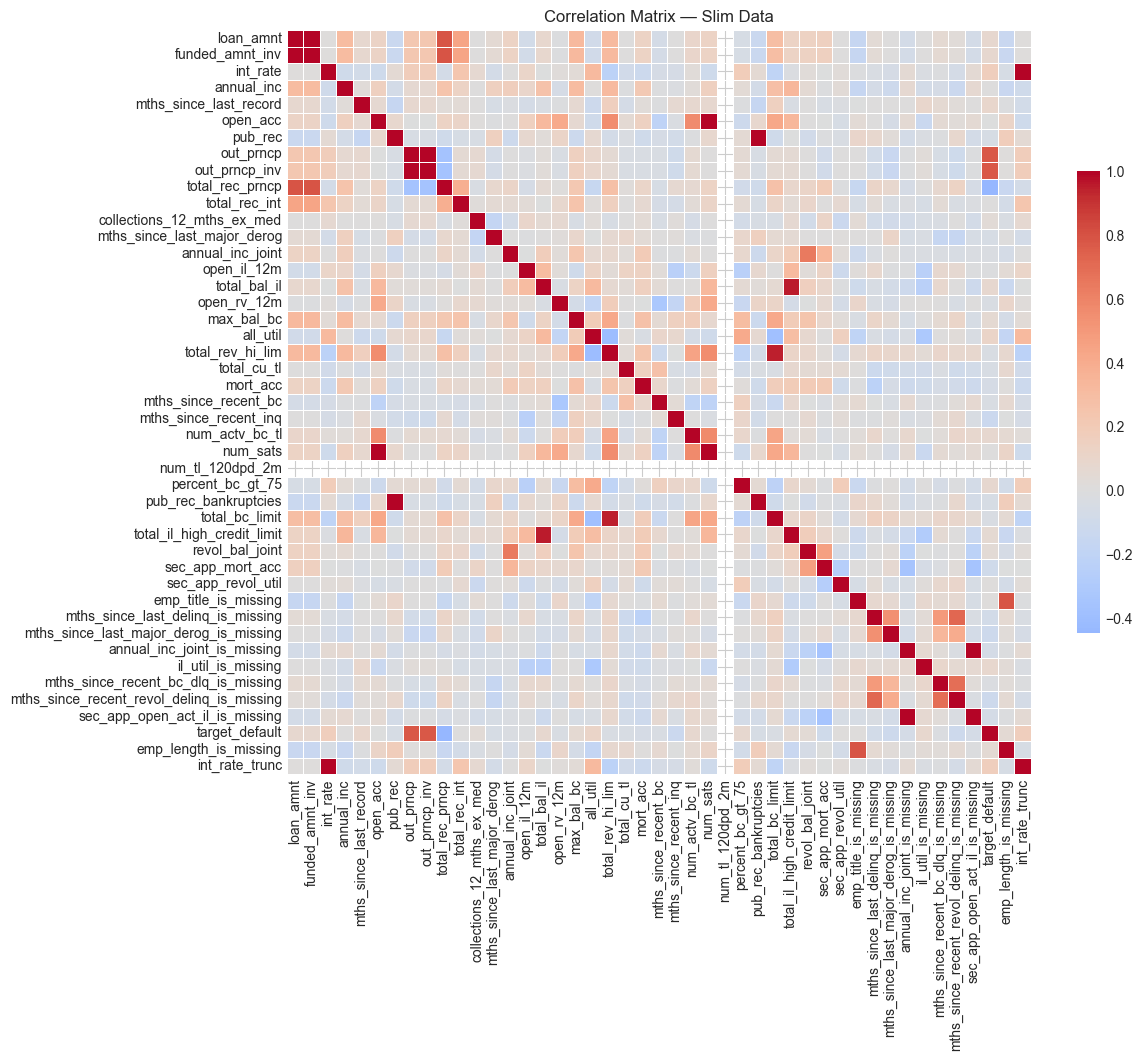

In [3]:
# Numeric-only correlation
corr = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True,
            cbar_kws={"shrink": .6}, linewidths=0.5)
plt.title("Correlation Matrix — Slim Data")
plt.show()

In [4]:
df.shape

(298, 55)

In [ ]:
# --- Target vs Feature Correlation ---
target = "target_default"

# Correlation matrix
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Series of correlations with target (drop itself)
corr_with_target = corr_matrix[target].drop(target)

# Sort by absolute value
corr_with_target = corr_with_target.reindex(
    corr_with_target.abs().sort_values(ascending=False).index
)

# Display top correlations
print("Top correlations with target_default:")
display(corr_with_target.head(15))

# Plot bar chart
plt.figure(figsize=(8, 5))
corr_with_target.head(15).plot(kind="barh", color="steelblue")
plt.title("Top Numeric Feature Correlations with Default")
plt.xlabel("Correlation with target_default")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# --- Target Distribution ---
dist = df["target_default"].value_counts(normalize=True).rename("proportion")

print(dist)

plt.figure(figsize=(5,4))
sns.barplot(x=dist.index.astype(str), y=dist.values, palette="Set2")
plt.title("Target Distribution: Default vs Non-Default")
plt.ylabel("Proportion")
plt.xlabel("Target (0 = Paid, 1 = Default)")
for i, v in enumerate(dist.values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=10)
plt.ylim(0,1)
plt.show()

<div style="border:2px solid #FF9800; border-radius:10px; padding:14px; background:#FFF8E1">

<h3>⚠️ Target Distribution — Class Imbalance</h3>

- <b>Non-Default (0):</b> ~90% (86% on full data) 
- <b>Default (1):</b> ~10% (14% on full data) 

This imbalance means that a naive model predicting "0" for all cases would still achieve ~90% accuracy.  
Therefore, evaluation will emphasize **recall, precision, F1, ROC-AUC, and calibrated probabilities** rather than raw accuracy.  

</div>

<div style="border:2px solid #3F51B5; border-radius:10px; padding:16px; background:#f5f5ff">

<h3>⚙️ Scaling & Feature Transformation Strategy</h3>

**Why Scale?**  
Our dataset contains a mix of raw financial amounts (e.g., loan amounts, balances) and ratio-like indicators (e.g., interest rate, debt-to-income).  
These features exist on very different scales and distributions, which can bias distance-based models and gradient-based optimizers.  

**Approach**  
- **RobustScaler** → for highly skewed monetary features (e.g., loan_amnt, dti, revol_util).  
  - Robust to outliers, centers data by median, scales by IQR.  
- **StandardScaler** → for ratio-like or bounded features closer to normal distributions (e.g., int_rate, delinq_2yrs, total_acc).  
  - Mean-centered, unit variance scaling.  
- **Passthrough (no scaling)** → categorical features, which will be one-hot encoded.  
  - These are not numeric in nature, so scaling is unnecessary.

**Imbalance Handling**  
Target distribution is imbalanced (~90% non-default, ~10% default).  
We will:  
- Apply **class weights** to penalize misclassification of defaults more heavily.  
- Explore **threshold tuning** later to balance recall vs precision.  

This ensures preprocessing preserves interpretability while giving all models a fair chance to learn meaningful patterns.  

</div>

In [ ]:
X = df.drop(columns=["target_default"])
y = df["target_default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Full pipeline: preprocess + model
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:, 1]


In [ ]:
df["target_default"].isna().sum()

In [ ]:
df.shape